In [33]:
# !pip install langchain_community
# !pip install replicate
# !pip install scikit-learn
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn


import pandas as pd
from sklearn.datasets import load_diabetes
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from langchain_community.llms import Replicate
import os
from google.colab import userdata

import pandas as pd
from sklearn.datasets import load_diabetes
import numpy as np
import matplotlib.pyplot as plt

In [52]:
# Ambil token API
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token

# Model yang digunakan
model = "ibm-granite/granite-3.3-8b-instruct"

# Parameter Model IBM Granite
params = {
    "temperature": 0.3,
    "top_k": 0,
    "top_p": 0.3,
    "max_tokens": 150,
    "min_tokens": 20,
    "random_seed": 42,
    "repetition_penalty": 1.2,
    "stopping_criteria": ["\n\n", "##"]
}

# Inisialisasi model
llm = Replicate(
    model=model,
    replicate_api_token=api_token,
    model_kwargs=params
)

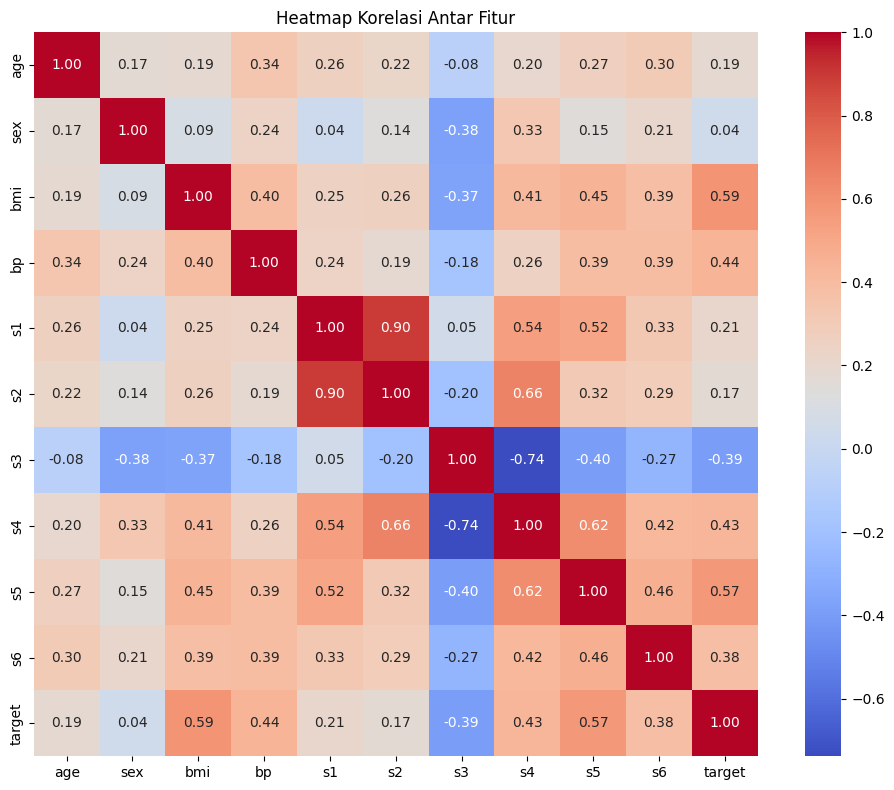

In [53]:
#Load Dataset
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

data = pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)
# Menambahkan kolom target
data['target'] = diabetes.target

data
corr_matrix = data.corr()

# Plot heatmap korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Heatmap Korelasi Antar Fitur")
plt.tight_layout()
plt.show()

In [54]:
#Pelabelan manual
def klasifikasi_risiko(nilai):
    if nilai < 100:
        return 'Rendah'
    elif nilai < 150:
        return 'Sedang'
    else:
        return 'Tinggi'

data['risiko'] = data['target'].apply(klasifikasi_risiko)


def buat_catatan(row):
    return (
        f"Pasien berusia relatif {'muda' if row['age'] < 0 else 'tua'}, "
        f"dengan tekanan darah sekitar {round(row['bp'], 2)}, "
        f"BMI sekitar {round(row['bmi'], 2)}, "
        f"dan skor metabolik s5: {round(row['s5'], 2)}."
    )

data['catatan_dokter'] = data.apply(buat_catatan, axis=1)
data[['catatan_dokter', 'risiko']].head(5)

,catatan_dokter,risiko
0,"Pasien berusia relatif tua, dengan tekanan dar...",Tinggi
1,"Pasien berusia relatif muda, dengan tekanan da...",Rendah
2,"Pasien berusia relatif tua, dengan tekanan dar...",Sedang
3,"Pasien berusia relatif muda, dengan tekanan da...",Tinggi
4,"Pasien berusia relatif tua, dengan tekanan dar...",Sedang


In [57]:
# Ambil 10 baris pertama
subset = data[['catatan_dokter', 'risiko']].head(5).copy()

# Kirim ke Granite: ringkasan risiko
ringkasan_outputs = []
saran_makanan_outputs = []

for catatan in subset['catatan_dokter']:
    # Prompt 1: Ringkasan dan klasifikasi risiko
    prompt_ringkasan = (
        f"Ringkas kondisi pasien ini dan sebutkan risiko: Rendah, Sedang, atau Tinggi, pake bahasa indonesia:\n\n{catatan}"
    )
    response1 = llm.invoke(prompt_ringkasan)
    ringkasan_outputs.append(response1)

    # Prompt 2: Saran makanan
    prompt_makanan = (
        f"Berdasarkan kondisi berikut, makanan apa saja yang sebaiknya dihindari dan dikonsumsi pasien ini?\n\n{catatan}"
    )
    response2 = llm.invoke(prompt_makanan)
    saran_makanan_outputs.append(response2)

# Tambahkan hasil ke subset
subset['Ringkasan Granite'] = ringkasan_outputs
subset['Saran Makanan dari Granite'] = saran_makanan_outputs

# Tampilkan hasil sebagai tabel
from IPython.display import display
display(subset)


,catatan_dokter,risiko,Ringkasan Granite,Saran Makanan dari Granite
0,"Pasien berusia relatif tua, dengan tekanan dar...",Tinggi,Kondisi pasien ini dapat dikenakan dalam kateg...,"Berdasarkan informasi yang diberikan, pasien i..."
1,"Pasien berusia relatif muda, dengan tekanan da...",Rendah,Kondisi pasien ini dapat dianggap sebagai risi...,"Berdasarkan informasi yang diberikan, ada bebe..."
2,"Pasien berusia relatif tua, dengan tekanan dar...",Sedang,Kondisi pasien ini dapat dianggap sebagai risi...,"Berdasarkan informasi yang diberikan, pasien i..."
3,"Pasien berusia relatif muda, dengan tekanan da...",Tinggi,Kondisi pasien ini dapat dianggap sebagai risi...,"Berdasarkan informasi yang diberikan, pasien i..."
4,"Pasien berusia relatif tua, dengan tekanan dar...",Sedang,Kondisi pasien ini adalah sebagai berikut:\n\n...,"Berdasarkan informasi yang diberikan, pasien i..."
